In [62]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

default = pd.read_csv("../../data/Default.csv")
default

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [63]:
import statsmodels.api as sm
from ISLP.models import ModelSpec as MS 

X = MS(["income", "balance"]).fit_transform(default)
y = default["default"] == "Yes"

results = sm.GLM(y, X, family=sm.families.Binomial()).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Fri, 25 Jul 2025   Deviance:                       1579.0
Time:                        21:11:42   Pearson chi2:                 6.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1256
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================
"""

In [64]:
def err_estimate(terms, target, df_train, df_valid, class1, class2):
    X_train = MS(terms).fit_transform(df_train)
    X_valid = MS(terms).fit_transform(df_valid)

    y_train = df_train[target] == "Yes"
    y_valid = df_valid[target]

    results = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()

    probs = results.predict(X_valid)

    labels = np.array([class1] * df_valid.shape[0])
    labels[probs>0.5] = class2

    return np.mean(labels != y_valid)

In [65]:
from sklearn.model_selection import train_test_split

errs = []

for i in range(3):
    default_train, default_valid = train_test_split(default, test_size=0.2, random_state=i)
    errs.append(err_estimate(["income", "balance"], "default", default_train, default_valid, "No", "Yes"))
errs

[np.float64(0.0395), np.float64(0.036), np.float64(0.0365)]

The validation errors across the three runs are very consistent, suggesting model stability with respect to the sample splits.

In [66]:
errs = []
for i in range(100):
    default_train, default_valid = train_test_split(default, test_size=0.2, random_state=i)
    errs.append(err_estimate(["income", "balance"], "default", default_train, default_valid, "No", "Yes"))

np.mean(errs)

np.float64(0.03651499999999999)

This confirms that the model achieves a stable validation error rate of approximately 3.65%.

In [67]:
default["student01"] = default["student"] == "Yes"
errs_stud = []

for i in range(100):
    default_train, default_valid = train_test_split(default, test_size=0.2, random_state=i)
    errs_stud.append(err_estimate(["income", "balance", "student01"], "default", default_train, default_valid, "No", "Yes"))
np.mean(errs_stud)

np.float64(0.03681999999999999)

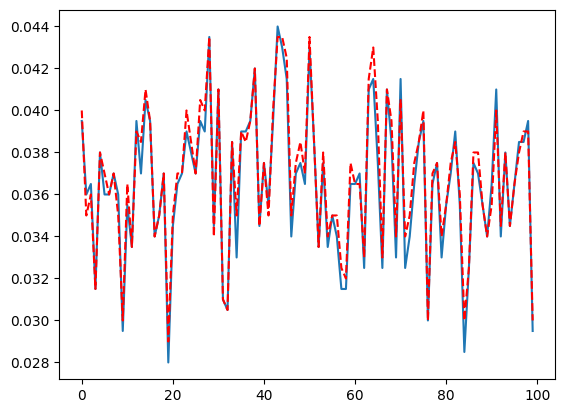

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

n = np.arange(100)
ax.plot(n, errs);
ax.plot(n, errs_stud, c='r', ls='--');

Adding the student dummy variable does not reduce the test error—in fact, the average error increases slightly (from 0.0365 to 0.0368). A plot of the two error series (with and without the student variable) confirms that there is no meaningful improvement in classification accuracy